# Object detection in images 

(tags: CNN, Object detection)

This work was inspired by [Johannes Rieke article on Medium](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) and by [Andrew Ng's Specialization Course on Deep Learning](https://www.coursera.org/specializations/deep-learning).

Rieke's work is interesting for the simplicity with which he creates a trainingset for our purpose - that is, developing bounding boxes that identify particular objects in an image. I dedicate myself in particular to the identification of several objects in the same image.

Rieke highlights a big risk: in the identification of N objects, the neural network ends up with not specializing and instead it develops 'average' bounding boxes - more or less equal - useless for our purpose. To solve this problem he proposes an algorithm for swapping the example's targets label between one epoch and another. A mechanism that did not convince me for two reasons:

- it considerably weighs the algorithm on a computational level (at the end of epoch the predictions of the network with the target values are compared).
- in the tests I did I could not get out of a sort of perpetual oscillation and at every epoch the percentage of swaps remained almost unchanged.

Conceptually starting from the work of Rieke I propose a solution that makes clear the importance of a preprocessing of our dataset. In fact, I create an order in the target values of our trainingset. I take as reference point the distance from one of the edges of the image (the origin in a coordinate system). 

As you can see it is an elegant solution that solves the problem upstream. Later I dedicate myself to improving the efficiency of the neural network.



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from keras import optimizers

%matplotlib inline

We create a simple image dataset. Each image will have a maximum size of 32x32 and will contain up to a maximum of N_bb objects (rectangles) with different shades of color. Their size will vary between a minimum of 1x1 and a maximum of 8x8. [To implement : If the color gradation (0-255) is less than or greater than a certain threshold (in our case <64), the object must not be detected.]

At the same time we define our bounding boxes. We will use 5 coordinates: a 'Pc', which indicates the percentage of confidence in the presence of an object; 'x' and 'y', for the spatial position of the top-left vertex and 'w' and 'h' for the extension (width and height).

In [0]:
N_imgs = 12500

# imagines side dimension
side_dim = 32 # 24

# objects min/max side dimensions
obj_min_dim = 2
obj_max_dim = 8 

# number of objects
N_bb = 4 # 4

# color thresholds
min_threshold = 0
max_threshold = 124

# confidence threshold
Pc_th = .0

# inizialization of images with a light gray color (just for aesthetic reasons)
imgs = np.ones((N_imgs, side_dim, side_dim,3)) * .9 

# inizialization of bounding boxes
bounding_boxes = np.zeros((N_imgs, N_bb, 5))


In [0]:
# inizialization of origin distance array
distance = np.zeros((N_imgs, N_bb))

# creation of objects in images and relative bounding boxes

for N_img in range(N_imgs):
    for i_ogg in range(N_bb):
        w = np.random.randint(obj_min_dim, obj_max_dim)
        h = np.random.randint(obj_min_dim, obj_max_dim)
        x = np.random.randint(0, side_dim - w)
        y = np.random.randint(0, side_dim - h)
          
        R = (np.random.randint(min_threshold, max_threshold)) / 255
        G = (np.random.randint(min_threshold, max_threshold)) / 255
        B = (np.random.randint(min_threshold, max_threshold)) / 255
        
        imgs[N_img, y:y+h, x:x+w, 0] = R 
        imgs[N_img, y:y+h, x:x+w, 1] = G 
        imgs[N_img, y:y+h, x:x+w, 2] = B 
        

        Pc = 1. # for the moment we use for all target value Pc = 1
        bounding_boxes[N_img, i_ogg] = [Pc, x, y, w, h]   
        
        # we calculate the distance from the origin for each Bounding Box
        distance[N_img, i_ogg] = np.sqrt(np.square(x+(w/2))+ np.square(y+(h/2)))


## Observation and pre-processing
First we analyze our datasets and start preprocessing them

In [4]:
# Let's look at the size of the Numpy arrays for images and bboxes 
print('Dimension of images array:', imgs.shape)
print('Dimension of BBoxes array:', bounding_boxes.shape)
print('Dimension of distance array:', distance.shape)

Dimension of images array: (12500, 32, 32, 3)
Dimension of BBoxes array: (12500, 4, 5)
Dimension of distance array: (12500, 4)


Imagine n. 11312


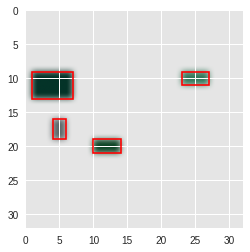

In [5]:
# We take a random image of our training set
im = np.random.randint(N_imgs)
print('Imagine n.', im)

# Let's look the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgs[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the corresponding bounding boxes
for i in range (N_bb):
  [Pc, x, y, w, h] = bounding_boxes[im, i]

# we consider only a percentage of confidence above the Pc_th
# (in our datasets we have Pc with values 0 or 1) but later
# Pc will assume probabilistic values between 0 and 1
  if Pc >= Pc_th:
    rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.6', fc='none')
    ax.add_patch(rect)

plt.show()

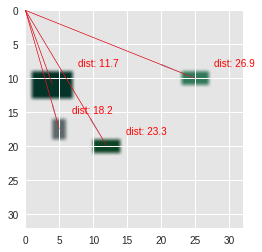

In [6]:
# We look at the image again, this time highlighting the distance of the objects from the origin ...
fig, ax = plt.subplots(1)

ax.imshow(imgs[im], origin = 'upper', interpolation = 'hanning', extent=[0, side_dim, side_dim, 0])

for i in range (N_bb):
  [Pc, x, y, w, h] = bounding_boxes[im, i]

  if Pc >= Pc_th:
    line = patches.Arrow(0, 0, x+(w/2), y+(h/2), .2, ec='r') 
    ax.add_patch(line)
    dida = 'dist: ' + '{:0.1f}'.format(distance[im,i])
    plt.annotate(dida, (x + w + 0.8 , y - 0.8), color='r')

plt.show()

We rearrange the bounding boxes based on the distance from the origin of the objects

In [0]:
order = np.zeros((N_imgs, N_bb), dtype=int)
bboxes = np.zeros(bounding_boxes.shape)

for i in range(N_imgs):
  order[i] = np.argsort(distance[i]) 
  for j in range(N_bb):
    bboxes[i,j] = (bounding_boxes[i, order[i,j]])

Let's start thinking in terms of Machine Learning. 
So we normalize the pixel values contained in our images to have values between -1 and 1 and transfer them to the input X values.

In [9]:
X = (imgs - np.mean(imgs)) / np.std(imgs)
print(X.shape, np.mean(imgs), np.std(imgs))

# We also reshape our target Y 
Y = bboxes.reshape(N_imgs, -1) 
print(Y.shape)

(12500, 32, 32, 3) 0.8497801456290865 0.17905427436049365
(12500, 20)


Below we see an example of our X values

In [10]:
print('Images example', im, 'has shape:\n', X[im].shape, '\n')
print('And this is its values:\n', X[im])

Images example 11312 has shape:
 (32, 32, 3) 

And this is its values:
 [[[0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  ...
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]]

 [[0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  ...
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]]

 [[0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  ...
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]]

 ...

 [[0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  ...
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]]

 [[0.2804728 0.2804728 0.2804728]
  [0.2804728 0.2804728 0.2804728]
  [0.2

And then we observe one of our Y target values

In [11]:
print('...and the target values Y are:\n', Y[im])

...and the target values Y are:
 [ 1.  1.  9.  6.  4.  1.  4. 16.  2.  3.  1. 10. 19.  4.  2.  1. 23.  9.
  4.  2.]


We have a homogeneous dataset of the N_imgs elements that we now share in Training set, Validation set, and Test set in relation 80%, 10%, 10%.

In [12]:
i = int(0.8 * N_imgs)
j = int(0.1 * N_imgs)

X_train = X[:i]
Y_train = Y[:i]
train_ex = X_train.shape[0]

X_val = X[i:i+j]
Y_val = Y[i:i+j]
val_ex = X_val.shape[0]

X_test = X[i+j:]
Y_test = Y[i+j:]
test_ex = X_test.shape[0]

dim_test = j # useful for the future 

print('Below the dimensions of X and Y for Training set, Validation set, and Test set respectively\n')
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

Below the dimensions of X and Y for Training set, Validation set, and Test set respectively

(10000, 32, 32, 3) (10000, 20) (1250, 32, 32, 3) (1250, 20) (1250, 32, 32, 3) (1250, 20)


## The Neural Network
As always suggested by Andrew Ng, we create a model as quickly as possible to get a benchmark - and then borrow the model used by Rieke. The model, is inspired by other detection algorithms and uses three pairs of CNN-MaxPooling layers followed by two fully connected layers, for a total of about 460 thousand parameters.

In [13]:
model = Sequential()
model.add(Conv2D(48, kernel_size=(8, 8), strides=2, padding='same', activation='relu', input_shape=(side_dim,side_dim,3), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(96, kernel_size=(4, 4), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(192, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dropout(.4))
model.add(Dense(384, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(Y.shape[-1]))

summ = model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 48)        9264      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 96)          73824     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 192)         73920     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 192)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
__________

At least for the moment we do not worry too much about the efficiency of the loss function and the optimization algorithm. We use the Mean Squared Error for the first and Adadelta for the second.

Let's start with a cycle of 15 epochs, we will use mini-batch of size 16.

In [0]:
N_ep = 15
init_ep = 0
Batchs = 16
optimizer = 'adadelta'
loss = 'mse'

In [15]:
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 10000 samples, validate on 1250 samples
Epoch 1/15
10000/10000 [==============================] - 8s 780us/step - loss: 18.9215 - val_loss: 11.2849
Epoch 2/15
10000/10000 [==============================] - 6s 631us/step - loss: 11.7500 - val_loss: 9.7489
Epoch 3/15
10000/10000 [==============================] - 6s 629us/step - loss: 9.9185 - val_loss: 7.9276
Epoch 4/15
10000/10000 [==============================] - 6s 634us/step - loss: 9.1613 - val_loss: 8.1567
Epoch 5/15
10000/10000 [==============================] - 6s 632us/step - loss: 8.4449 - val_loss: 7.0324
Epoch 6/15
10000/10000 [==============================] - 6s 634us/step - loss: 7.9569 - val_loss: 6.7233
Epoch 7/15
10000/10000 [==============================] - 6s 635us/step - loss: 7.5654 - val_loss: 6.4889
Epoch 8/15
10000/10000 [==============================] - 6s 633us/step - loss: 7.1833 - val_loss: 6.9852
Epoch 9/15
10000/10000 [==============================] - 6s 633us/step - loss: 6.8872 - val_loss: 5

##Observation of results
We evaluate the results obtained. We use the Test Set for predictions and define a metric, the IoU (Intersection over Union) that supports those we already have for the training phase - loss error.

The Intersection over Union is an incredibly effective measure to understand how much our forecasts approach the correct bounding boxes of the objects in the images. It has values that oscillate between 0 and 1 and the closer they are to 1, the more the area of our predictions approaches that of the correct bounding boxes.

In [0]:
# We define one of the reference metrics to analyze our results
# the Intersection over Union that measures the correspondence 
# of our predictions with the actual bounding boxes

def IoU(box1, box2):
  '''Intersection over Union (IoU) between box1 and box2
    
  Arguments:
  box1 -- first box, with coordinates (x, y, w, h)
  box2 -- second box, with coordinates (x2, y2, w2, h2)
  
  Returns:
  iou -- scalar
  '''    
  [x, y, w, h] = box1
  [x2, y2, w2, h2] = box2
    
  # Intesection area 
  xi1 = np.maximum(x, x2)
  yi1 = np.maximum(y, y2)
  xi2 = np.minimum(x+w, x2+w2)
  yi2 = np.minimum(y+h, y2+h2)
  xi = np.maximum(0., xi2-xi1)
  yi = np.maximum(0., yi2-yi1)
  
  inter_area = np.multiply(xi,yi)

  # Union area
  box1_area = (w*h)
  box2_area = (w2*h2)
  union_area = box1_area+box2_area-inter_area
  
  # Calculation of IoU
  iou = inter_area/union_area

  return iou



But first let's take a look at our predictions.

In [0]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

In [19]:
# And the expected bboxes of our Test set
expe_bboxes = Y_test.reshape(dim_test, N_bb, -1)

# Their dimensions
pred_bboxes.shape, expe_bboxes.shape

((1250, 4, 5), (1250, 4, 5))

Test images: 196
Object:  1
B-box confidence: 1.0
B-box coordinates: [0.18 1.01 3.98 3.73]
Object coordinates: [1.00 0.00 6.00 5.00]
Test images: 196
Object:  2
B-box confidence: 1.0
B-box coordinates: [8.76 2.02 3.94 3.90]
Object coordinates: [6.00 1.00 2.00 2.00]
Test images: 196
Object:  3
B-box confidence: 1.0
B-box coordinates: [17.50 5.68 4.25 3.99]
Object coordinates: [23.00 5.00 2.00 4.00]
Test images: 196
Object:  4
B-box confidence: 1.0
B-box coordinates: [9.45 19.44 4.71 4.58]
Object coordinates: [9.00 21.00 6.00 7.00]


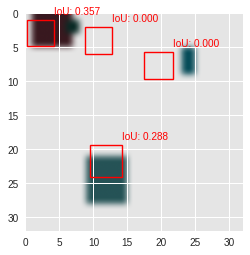

In [20]:
imgTest = (np.reshape(X_test, (dim_test, side_dim, side_dim, 3)) * np.std(imgs)) + np.mean(imgs)

# Consider a random image of our Test set
im = np.random.randint(dim_test)

# We look at the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgTest[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the bounding boxes predicted by the algorithm
for i in range (N_bb):
  [x , y, w, h] = pred_bboxes[im, i, 1:] 

  [x2, y2, w2, h2] = expe_bboxes[im, i, 1:] 
    
  rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.4', fc='none')

  dida = 'IoU: ' + '{:0.3f}'.format(IoU([x,y,w,h], [x2,y2,w2,h2]))
  plt.annotate(dida, (x + w , y - 0.8), color='r')

  print('Test images:', im)
  print('Object: ', i+1)
  print('B-box confidence:', Pc)
  print('B-box coordinates:', '[{:0.2f}'.format(x), '{:0.2f}'.format(y), '{:0.2f}'.format(w), '{:0.2f}]'.format(h))
  print('Object coordinates:', '[{:0.2f}'.format(x2), '{:0.2f}'.format(y2), '{:0.2f}'.format(w2), '{:0.2f}]'.format(h2))

  ax.add_patch(rect)

plt.show()

### Evaluation of results
Now we evaluate the results, first by calculating the average IoU for predictions on our Test set.

In [0]:
# We measure the average IoU of the whole test set 
def mean_IoU(expe_bboxes, pred_bboxes, dim_test, N_bb):

  IoU_test = np.zeros((dim_test, N_bb)) 
  iou_global = 0

  for i in range(dim_test):
    for j in range(N_bb):

      [x , y, w, h] = pred_bboxes[i, j, 1:] 
      [x2, y2, w2, h2] = expe_bboxes[i, j, 1:] 

      IoU_test[i,j] = IoU([x,y,w,h], [x2,y2,w2,h2])

  iou_global = np.mean(IoU_test)
  return iou_global

**Mean Intersection over Union of all Test set after 15 epochs:** 

In [22]:
print(mean_IoU(expe_bboxes, pred_bboxes, dim_test, N_bb))

0.18078085648531456


Let's try to go on with the training phase for another 15 epochs and see what happens. First we save the values of the training / validation loss to observe them later.

In [0]:
# we save value of training/validation loss  
val_loss = []
train_loss = []

val_loss = history.history['val_loss']
train_loss = history.history['loss']

In [0]:
N_ep = 30
init_ep = 15
Batchs = 16

In [25]:
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 10000 samples, validate on 1250 samples
Epoch 16/30
10000/10000 [==============================] - 7s 718us/step - loss: 5.6612 - val_loss: 5.6386
Epoch 17/30
10000/10000 [==============================] - 7s 670us/step - loss: 5.3024 - val_loss: 5.4984
Epoch 18/30
10000/10000 [==============================] - 7s 669us/step - loss: 5.1518 - val_loss: 5.6012
Epoch 19/30
10000/10000 [==============================] - 7s 668us/step - loss: 4.9928 - val_loss: 5.3931
Epoch 20/30
10000/10000 [==============================] - 7s 675us/step - loss: 4.9418 - val_loss: 5.5105
Epoch 21/30
10000/10000 [==============================] - 7s 674us/step - loss: 4.7711 - val_loss: 5.2539
Epoch 22/30
10000/10000 [==============================] - 7s 671us/step - loss: 4.7234 - val_loss: 5.3110
Epoch 23/30
10000/10000 [==============================] - 7s 676us/step - loss: 4.5878 - val_loss: 5.3972
Epoch 24/30
10000/10000 [==============================] - 7s 665us/step - loss: 4.5639 - val_l

**Mean Intersection over Union of all Test set after 30 epochs:** 

In [26]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

# The value of the IoU
print(mean_IoU(expe_bboxes, pred_bboxes, dim_test, N_bb))

0.22111415324143183


Let's now put on a graph the progress of the training phase for the Training set and the Validation set, with a graph of the Loss.

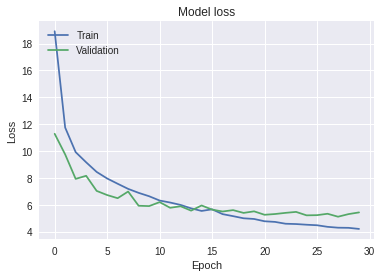

In [27]:
# We add the value of the loss of the new training phase
val_loss += history.history['val_loss']
train_loss += history.history['loss']

# Plot training & validation loss values
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The graphs show how the network is learning. But let's go even further...

In [28]:
N_ep = 100
init_ep = 30
Batchs = 16
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 10000 samples, validate on 1250 samples
Epoch 31/100
10000/10000 [==============================] - 7s 709us/step - loss: 4.3260 - val_loss: 5.5203
Epoch 32/100
10000/10000 [==============================] - 7s 667us/step - loss: 4.1599 - val_loss: 5.1663
Epoch 33/100
10000/10000 [==============================] - 7s 672us/step - loss: 4.1173 - val_loss: 5.1312
Epoch 34/100
10000/10000 [==============================] - 7s 675us/step - loss: 4.0439 - val_loss: 5.3884
Epoch 35/100
10000/10000 [==============================] - 7s 673us/step - loss: 3.9599 - val_loss: 5.2167
Epoch 36/100
10000/10000 [==============================] - 7s 668us/step - loss: 3.9321 - val_loss: 5.1581
Epoch 37/100
10000/10000 [==============================] - 7s 673us/step - loss: 3.9008 - val_loss: 5.2607
Epoch 38/100
10000/10000 [==============================] - 7s 669us/step - loss: 3.8464 - val_loss: 5.1893
Epoch 39/100
10000/10000 [==============================] - 7s 669us/step - loss: 3.815

**Mean Intersection over Union of all Test set after 100 epochs:** 

In [29]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

# The value of the IoU
print(mean_IoU(expe_bboxes, pred_bboxes, dim_test, N_bb))

0.25092916076338595


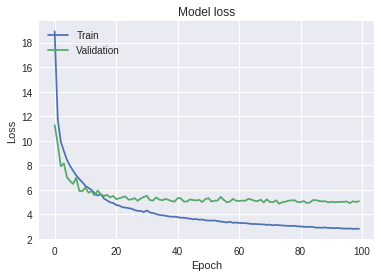

In [30]:
# We add the value of the loss of the new training phase
val_loss += history.history['val_loss']
train_loss += history.history['loss']

# Plot training & validation loss values
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The loss validation tells us that around the 80th age the network stops learning (even if the training loss continues to decrease). Considering the anomalous trend of loss validation and the IoU which in the end has improved, I try to go on with training for another 30 epochs.


In [31]:
N_ep = 130
init_ep = 100
Batchs = 16
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 10000 samples, validate on 1250 samples
Epoch 101/130
10000/10000 [==============================] - 7s 718us/step - loss: 2.9279 - val_loss: 5.1484
Epoch 102/130
10000/10000 [==============================] - 7s 670us/step - loss: 2.8319 - val_loss: 4.9714
Epoch 103/130
10000/10000 [==============================] - 7s 667us/step - loss: 2.7811 - val_loss: 5.1509
Epoch 104/130
10000/10000 [==============================] - 7s 668us/step - loss: 2.8192 - val_loss: 5.0141
Epoch 105/130
10000/10000 [==============================] - 7s 669us/step - loss: 2.7729 - val_loss: 5.0471
Epoch 106/130
10000/10000 [==============================] - 7s 670us/step - loss: 2.7757 - val_loss: 5.0245
Epoch 107/130
10000/10000 [==============================] - 7s 676us/step - loss: 2.7893 - val_loss: 4.9318
Epoch 108/130
10000/10000 [==============================] - 7s 673us/step - loss: 2.7432 - val_loss: 5.0329
Epoch 109/130
10000/10000 [==============================] - 7s 669us/step - lo

We just take a look to a new prediction examples.

Test images: 535
Object:  1
B-box confidence: 1.0
B-box coordinates: [6.62 16.01 4.96 5.43]
Object coordinates: [7.00 17.00 6.00 6.00]
Test images: 535
Object:  2
B-box confidence: 1.0
B-box coordinates: [11.20 18.32 3.80 4.30]
Object coordinates: [15.00 18.00 2.00 4.00]
Test images: 535
Object:  3
B-box confidence: 1.0
B-box coordinates: [12.07 21.62 3.13 4.62]
Object coordinates: [12.00 21.00 4.00 3.00]
Test images: 535
Object:  4
B-box confidence: 1.0
B-box coordinates: [22.52 27.51 2.68 2.17]
Object coordinates: [21.00 27.00 3.00 2.00]


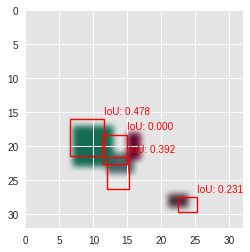

In [33]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

# Consider a random image of our Test set
im = np.random.randint(dim_test)

# We look at the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgTest[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the bounding boxes predicted by the algorithm
for i in range (N_bb):
  [x , y, w, h] = pred_bboxes[im, i, 1:] 

  [x2, y2, w2, h2] = expe_bboxes[im, i, 1:] 
    
  rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.4', fc='none')

  dida = 'IoU: ' + '{:0.3f}'.format(IoU([x,y,w,h], [x2,y2,w2,h2]))
  plt.annotate(dida, (x + w , y - 0.8), color='r')

  print('Test images:', im)
  print('Object: ', i+1)
  print('B-box confidence:', Pc)
  print('B-box coordinates:', '[{:0.2f}'.format(x), '{:0.2f}'.format(y), '{:0.2f}'.format(w), '{:0.2f}]'.format(h))
  print('Object coordinates:', '[{:0.2f}'.format(x2), '{:0.2f}'.format(y2), '{:0.2f}'.format(w2), '{:0.2f}]'.format(h2))

  ax.add_patch(rect)

plt.show()

**Mean Intersection over Union of all Test set after 130 epochs:** 

In [34]:
# The value of the IoU
print(mean_IoU(expe_bboxes, pred_bboxes, dim_test, N_bb))

0.26887294045182364


##Conclusions
The experiment described lasted just few minutes taking advantage of the Google Colab GPU. Even so, it shows the learning ability of the algorithm and the effectiveness of the solution we have adopted to avoid falling into the problem of undifferentiated bounding-boxes exposed by Rieke. In particular, it highlights the importance of pre-processing operations.

The network trained for over 100 epochs (in a dozen minutes) continues to learn up to a certain point - around 80th epoch - but the trend of the validation loss is anomalous, being initially lower than the training loss. This and other issues need to be investigated - beginning with considering the use of a different loss function.

The display of results for the Test-set shows the differentiation of bounding boxes. The value of the IoU is also very indicative. The IoU proves to be perhaps the best metric for a tuning operation on the neural network, so it should be implemented in the algorithm and evaluated at the Validation-set level.

Anyway, the network is certainly improvable. From this base I will carry out other experiments on other Jupyter notebooks by carefully tuning hyperparations, using larger and more complex datasets.